# Liver Cirhosis Classification

## Data Preprocessing

In [790]:
import copy
import random
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score,roc_curve,auc,confusion_matrix,cohen_kappa_score
from sklearn.model_selection import GridSearchCV,train_test_split

random.seed(2023)

In [791]:
#Load Dataset
cir_df = pd.read_csv("cirrhosis.csv")
#Check duplicate
len(pd.unique(cir_df["ID"])) == len(cir_df.index)

True

### Missing Value

In [792]:
#Check missing values
cir_df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

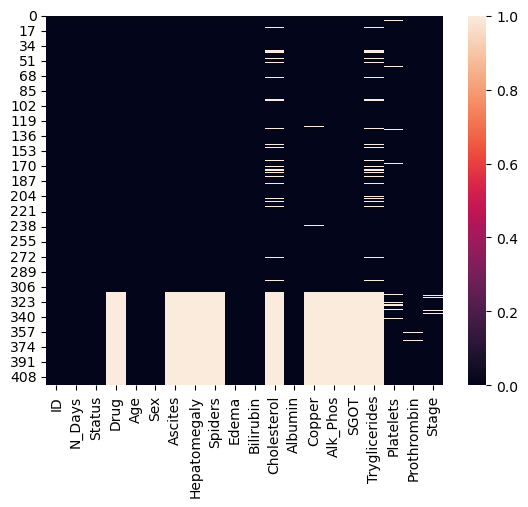

In [793]:
sns.heatmap(cir_df.isnull())
plt.show()

From the heat map above, we can tell there are around 100 patients missing nearly 50% features, and some of those features are bianry. Arbitrarily imputing those values with mean/mode could lead to huge misleading since this is a small dataset and those patients compose nearly 25% of the dataset. So we decide to remove those patients and impute the rest of missing values with means.

Furthermore, certain variables have been transformed in order to enhance comprehensibility and proceed more convenient fitting later.

In [794]:
cir_df = cir_df.drop(columns = ["ID"])
#Drop rows with too much null value
cir_df = cir_df[cir_df["Drug"].isna() == False]
#Impute other null value with median
fill_values = {"Tryglicerides": np.nanmedian(cir_df["Tryglicerides"]), 
               "Platelets": np.nanmedian(cir_df["Platelets"]), 
               "Cholesterol": np.nanmedian(cir_df["Cholesterol"]), 
               "Copper": np.nanmedian(cir_df["Copper"])}
cir_df = cir_df.fillna(value = fill_values)
#Convert age into year
cir_df["Age"] = (cir_df["Age"]/365).astype('int')
#Replace binary values with 0,1
cir_df["Sex"] = np.where(cir_df["Sex"] == "M",1,0)
cir_df["Ascites"] = np.where(cir_df["Ascites"] == "Y",1,0)
cir_df["Hepatomegaly"] = np.where(cir_df["Hepatomegaly"] == "Y",1,0)
cir_df["Spiders"] = np.where(cir_df["Spiders"] == "Y",1,0)
cir_df["Drug"] = np.where(cir_df["Drug"] == "D-penicillamine",1,0)

In [795]:
cir_df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,1,58,0,1,1,1,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,1,56,0,0,1,1,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,1,70,1,0,0,0,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,1,54,0,0,1,1,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,0,38,0,0,1,1,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## EDA

In [796]:
cir_df.describe()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000
mean,2006.362179,0.506410,49.538462,0.115385,0.076923,0.512821,0.288462,3.256090,364.125000,3.520000,97.490385,1982.655769,122.556346,123.096154,261.871795,10.725641,3.032051
std,1123.280843,0.500762,10.590528,0.319999,0.266897,0.500639,0.453775,4.530315,221.923027,0.419892,85.360932,2140.388824,56.699525,62.122820,94.993533,1.004323,0.877880
min,41.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1191.000000,0.000000,41.750000,0.000000,0.000000,0.000000,0.000000,0.800000,255.750000,3.310000,41.750000,871.500000,80.600000,87.000000,200.000000,10.000000,2.000000
50%,1839.500000,1.000000,49.000000,0.000000,0.000000,1.000000,0.000000,1.350000,309.500000,3.550000,73.000000,1259.000000,114.700000,108.000000,257.000000,10.600000,3.000000
75%,2697.250000,1.000000,56.000000,0.000000,0.000000,1.000000,1.000000,3.425000,392.250000,3.800000,123.000000,1980.000000,151.900000,145.250000,322.000000,11.100000,4.000000
max,4556.000000,1.000000,78.000000,1.000000,1.000000,1.000000,1.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,4.000000


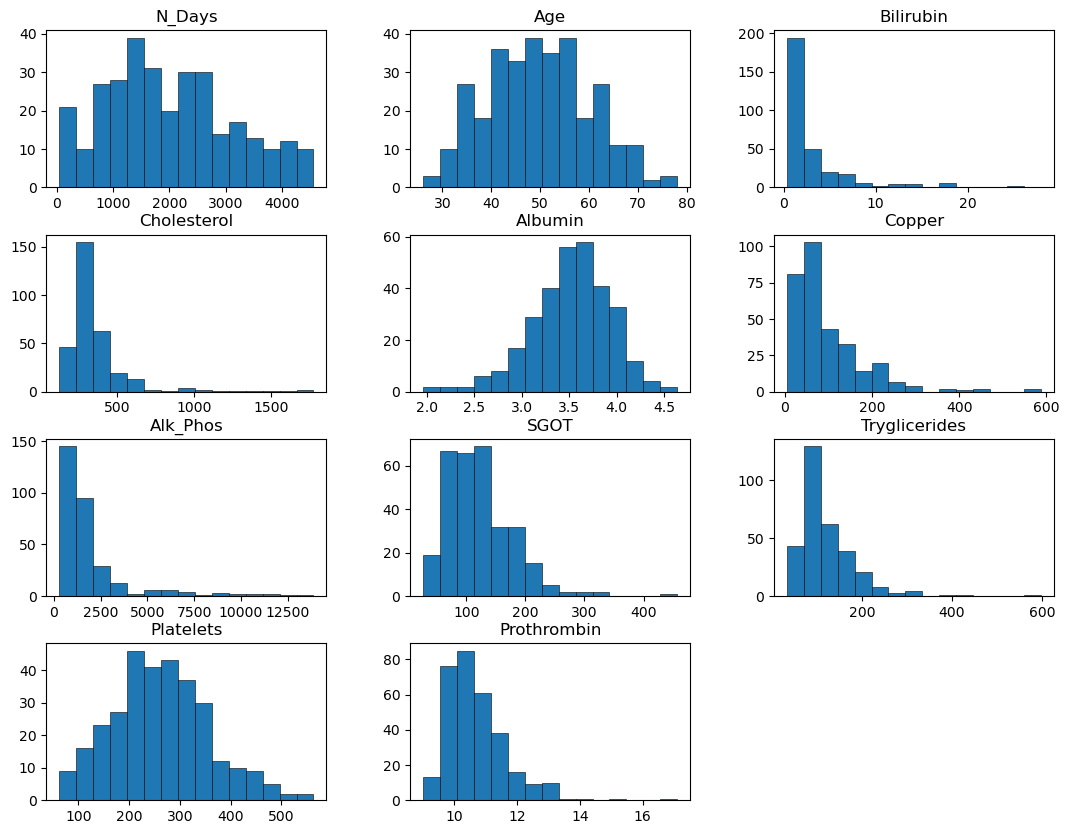

In [797]:
continous_df = cir_df.loc[:, ~cir_df.columns.isin(['Status', 'Stage', 'Edema','Drug','Sex','Ascites','Hepatomegaly','Spiders'])]
histogram = continous_df.hist(figsize=(13, 10), bins = 15 ,grid = False, edgecolor='black', linewidth = 0.4)

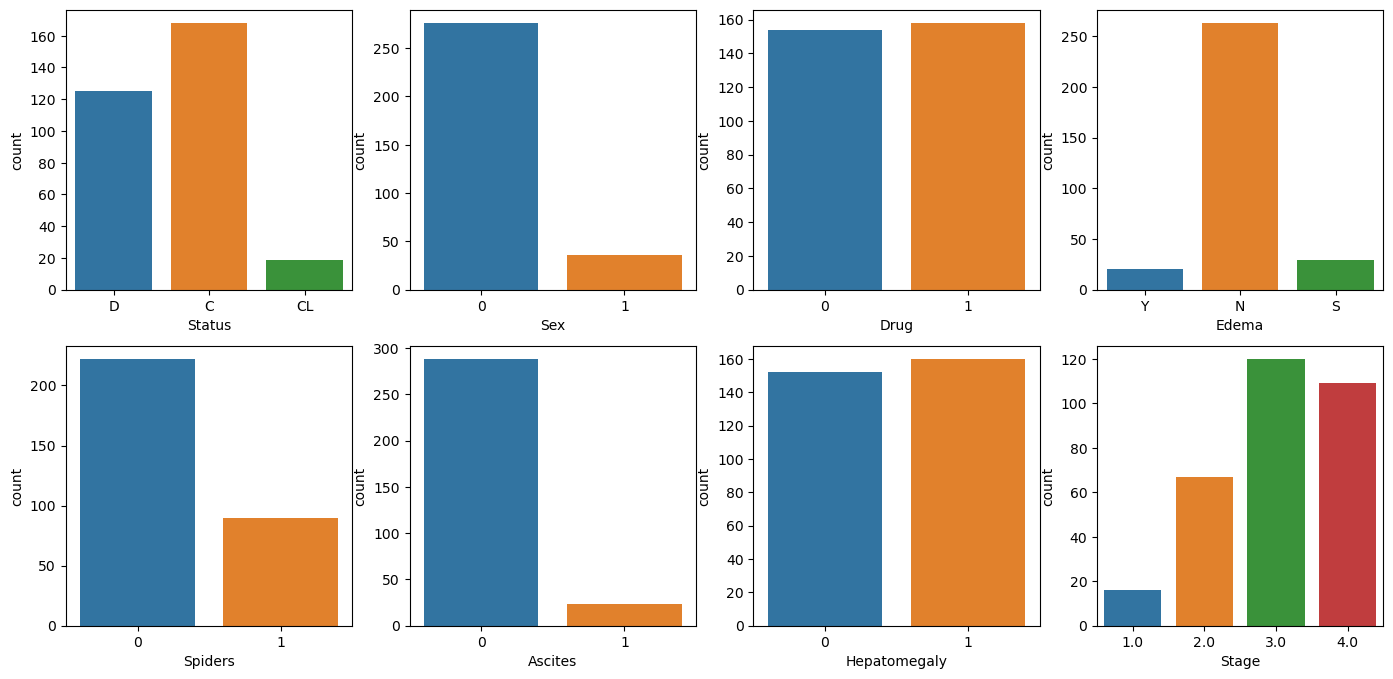

In [798]:
category_df = cir_df.loc[:, cir_df.columns.isin(['Status', 'Stage', 'Edema','Drug','Sex','Ascites','Hepatomegaly','Spiders'])]
fig, ax = plt.subplots(2, 4, figsize = (17,8))
axis = [['Status', 'Sex','Drug','Edema'],['Spiders','Ascites','Hepatomegaly','Stage']]
for i in range(2):
    for j in range(4):
        subplot = sns.countplot(ax = ax[i,j] ,x = axis[i][j], data = category_df)

### Correlation Map

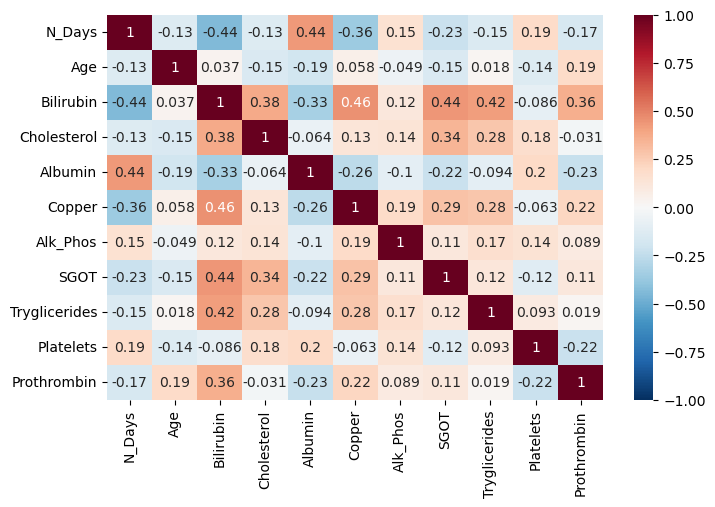

In [799]:
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(continous_df.corr(), cmap = 'RdBu_r', vmin=-1, vmax=1, annot=True)

### Distribution of variables based on whether have cirrhosis

Since the size of dataset is pretty small, and the distribution of target varible is imbalaced, it would be extra challenging to perform the multiclass classification task (predicting disease stage). Hence the target would be combined to binary form. According to METAVIR metrics, stage1-3 represent different severity of liver firbrosis, and stage4 represents irreversible liver cirrhosis. Target stage would be encoded in binary format, where stage4 = 1 and other stages = 0.

Looking at the distribution of the numerical features, `Bilirubin`, `Age`, `Prothrombin`, `Copper` are suspected to be positively related to the risk of liver cirrhosis.

In [801]:
cir_df["Stage"] = np.where(cir_df["Stage"] == 4,1,0)

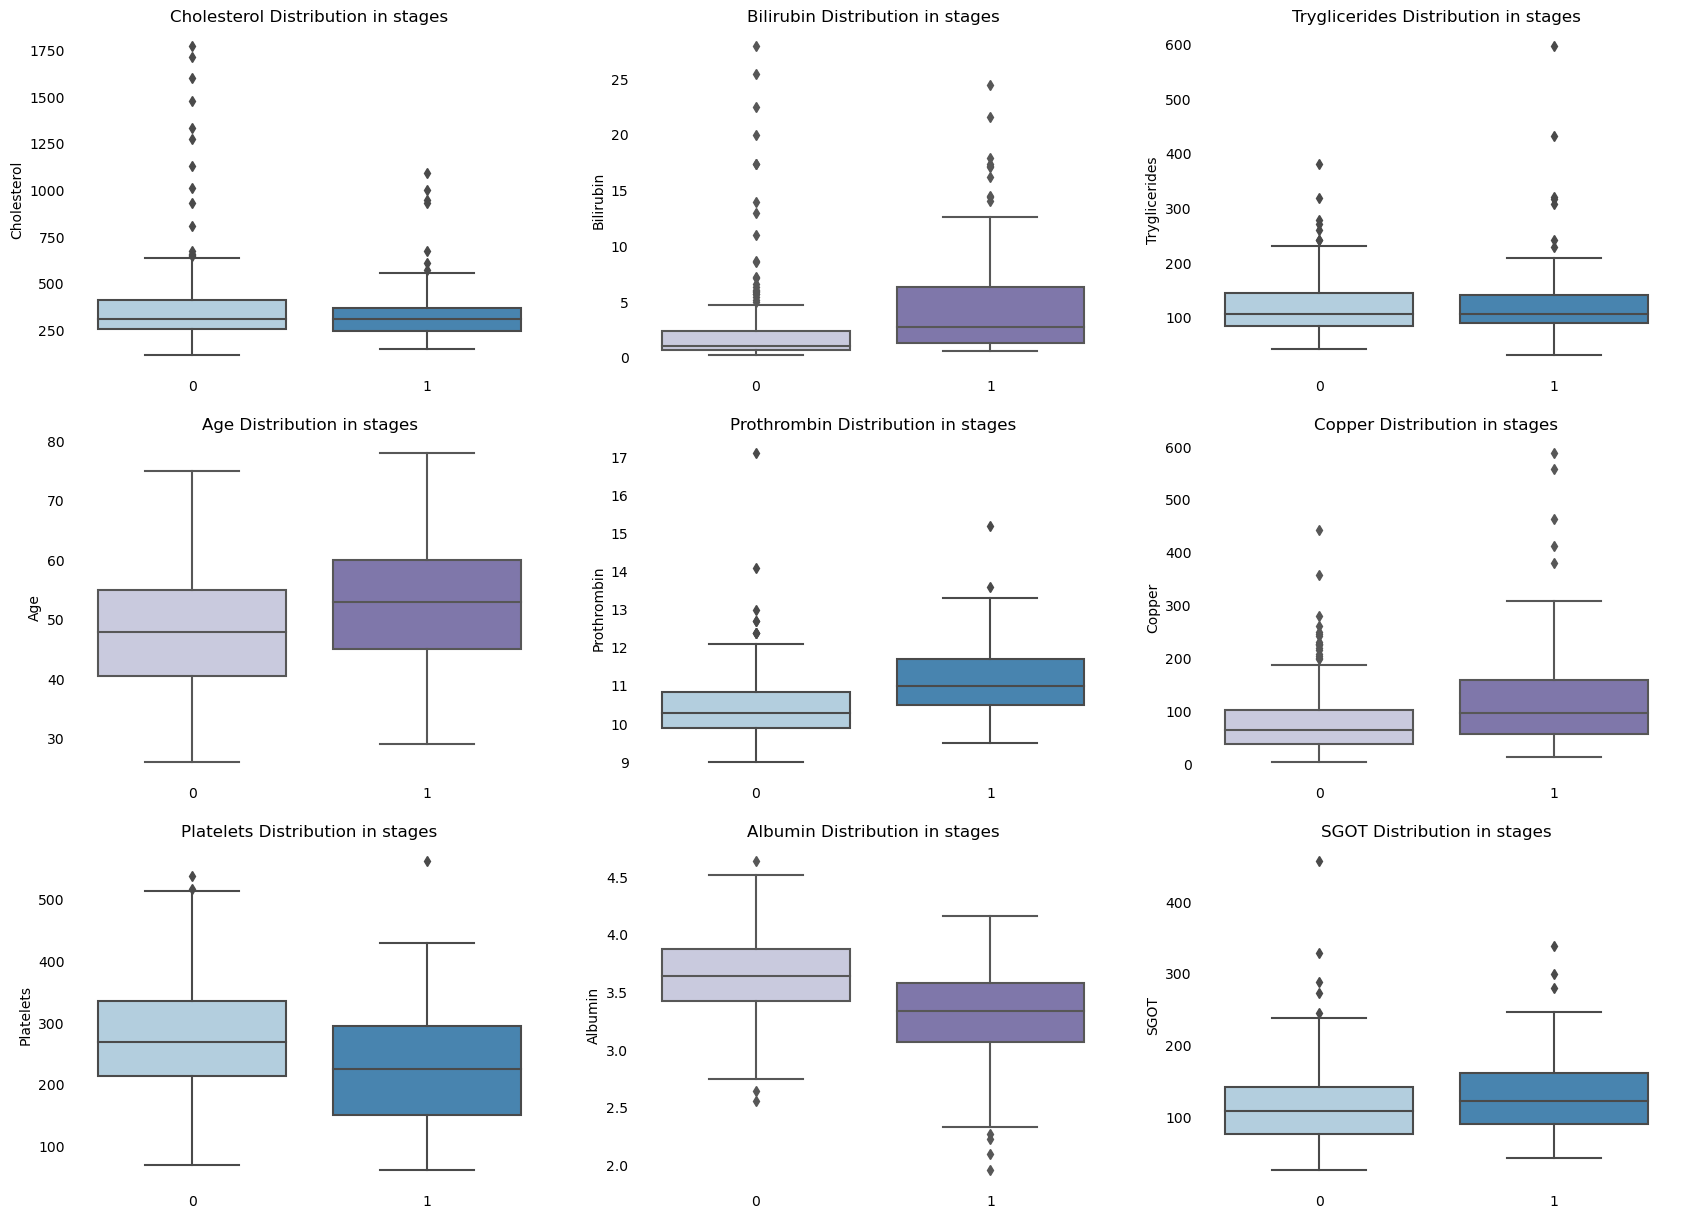

In [802]:
plt.figure(figsize=(20.6,15))
col = ['Cholesterol','Bilirubin','Tryglicerides','Age','Prothrombin','Copper',
       'Platelets','Albumin','SGOT']

for i in range(len(col)):
    var = col[i]
    if i%2 == 0:
        color = 'Blues'
    else:
        color = 'Purples'
    plt.subplot(3,3,i+1)
    sns.boxplot(x='Stage', y=var, data=cir_df, palette=color)
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
    plt.xlabel('')
    plt.title(var + ' Distribution in stages');

In [672]:
cir_df = cir_df.drop(columns = ['Status','N_Days'])

## Model

Before fitting the model, there is still some manipulations needed to make the dataset eligible to the model.

First, our target `Stage` is seperated from features.

In [673]:
target = cir_df["Stage"]

Most of the features in the dataset is either binary or continuous. Edema is a feature having multiple category ("N","S", and "Y"). In order to make this fit the classifier model, one-hot coding is required. `pd.get_dummies()` is used to achieve this by pivot Edema into 3 separate columns.

In [674]:
features = cir_df.drop(columns = ["Stage"])
features["Edema"] = features["Edema"].astype('category')
features = pd.get_dummies(features)

features["Edema_Y"] = features["Edema_Y"].astype('int')
features["Edema_S"] = features["Edema_S"].astype('int')
#Edema_N is droped since a full rank encoding might cause colliearity issue is some models we use.
features = features.drop(columns = ["Edema_N"])

`SMOTE()` is applied to oversamle out the minor class 1.

In [675]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
features,target = smote.fit_resample(features,target)

Standard scaling is required to speed up the convergence of MLP and sklearn's logistic model. Most continous columns with relative large range are scaled using `ColumnTransformer()` and `StandardScaler()`.

In [676]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


sc = ColumnTransformer([
    ('somename', StandardScaler(), ['Age', 'Bilirubin','Albumin','Copper','Alk_Phos','Tryglicerides','Platelets','Prothrombin'])],
    remainder='passthrough')

X_scaled = sc.fit_transform(features)

20% of data is used as test data to validate the performance of the models.

In [677]:
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled, target, test_size=0.2,random_state=23)

### Logistics Regression

Logistic regression model is good at predicting binary class. After it's fitted, test/training set prediction accuracy is generated to check overfitting. ROC curve and confusion matrix is also produced.

In [738]:
from sklearn.linear_model import LogisticRegressionCV
lr_model = LogisticRegressionCV(cv = 10,max_iter=1000).fit(X_scaled_train,y_scaled_train)

In [739]:
print('Trian set prediction accuracy: {:.4f}'.format(accuracy_score(y_scaled_train,lr_model.predict(X_scaled_train))))
print('Test set prediction accuracy: {:.4f}'.format(accuracy_score(y_scaled_test,lr_model.predict(X_scaled_test))))

Trian set prediction accuracy: 0.8117
Test set prediction accuracy: 0.7317


In [740]:
def roc_plot(classifier_list,name_list,xtest,ytest,xgbx = X_xgb_test,xgby = y_xgb_test):
    for i in range(len(classifier_list)):
        classifier = classifier_list[i]
        name = name_list[i]
        if name == 'XGBoost':
            y_proba = classifier.predict_proba(xgbx)
            fpr, tpr, thresholds = roc_curve(xgby, y_proba[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label= name + ' (AUC = %0.2f)' % roc_auc)
        else:
            y_proba = classifier.predict_proba(xtest)
            fpr, tpr, thresholds = roc_curve(ytest, y_proba[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label= name + ' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label = 'Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve and AUC')
    plt.legend(loc="lower right")
    plt.show()
    return

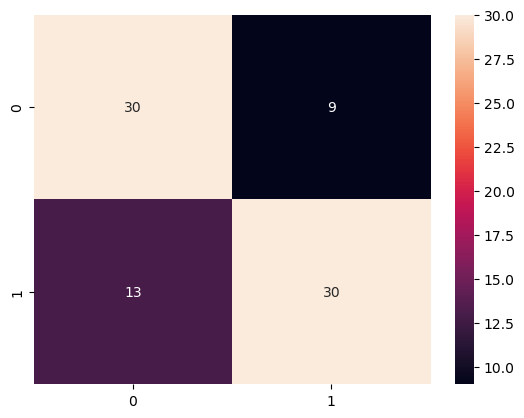

In [741]:
sns.heatmap(confusion_matrix(lr_model.predict(X_scaled_test),y_scaled_test),annot=True)
plt.show()

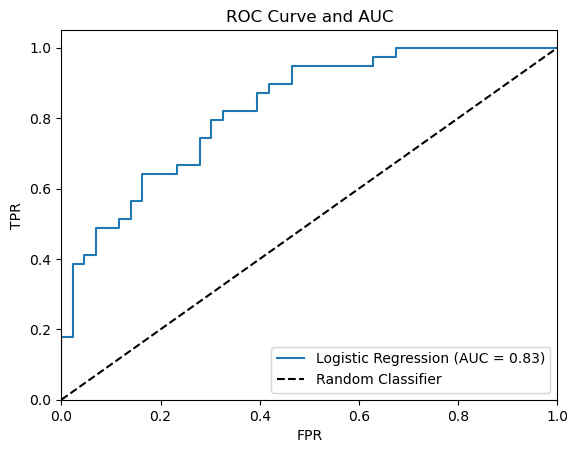

In [742]:
roc_plot([lr_model],['Logistic Regression'],X_scaled_test,y_scaled_test)

In [565]:
print('Null accuracy score: {0:0.4f}'. format(39/(39+43)))

Null accuracy score: 0.4756


### Multilayer Perceptron Neural Network

In [770]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier()

In [771]:
param_grid = {
    'hidden_layer_sizes': [(i,) for i in range(1,10)] + [(i,j) for i in range(4,10) for j in range(1,i)],
    'max_iter': [3000,4000],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.0005,0.001,0.005,0.01]
}

In [772]:
mlp_grid = GridSearchCV(mlp_model, param_grid,
                    n_jobs= -1, 
                    cv=10,
                    scoring = 'roc_auc')
mlp_grid.fit(X_scaled_train, y_scaled_train)
print(mlp_grid.best_params_)

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (9,), 'max_iter': 3000, 'solver': 'adam'}


In [773]:
print('Trian set prediction accuracy: {:.2f}'.format(accuracy_score(y_scaled_train, mlp_grid.predict(X_scaled_train))))
print('Test set prediction accuracy: {:.2f}'.format(accuracy_score(y_scaled_test, mlp_grid.predict(X_scaled_test))))

Trian set prediction accuracy: 0.81
Test set prediction accuracy: 0.72


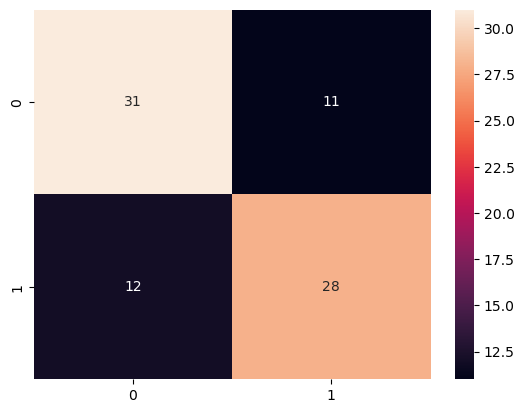

In [774]:
sns.heatmap(confusion_matrix(mlp_grid.predict(X_scaled_test),y_scaled_test),annot=True)
plt.show()

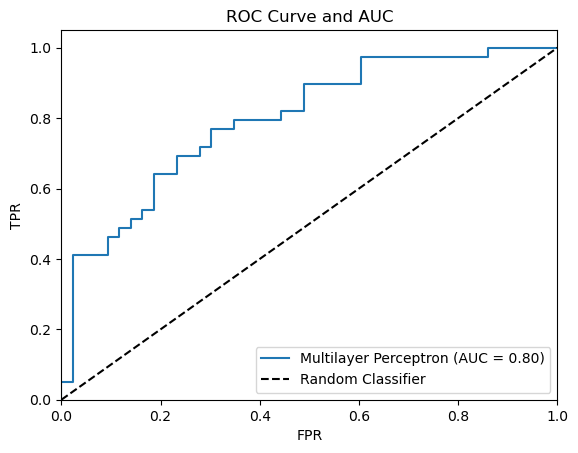

In [775]:
roc_plot([mlp_grid.best_estimator_],['Multilayer Perceptron'],X_scaled_test,y_scaled_test)

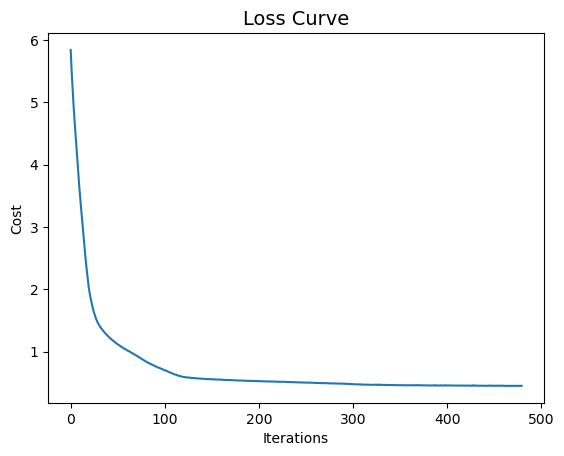

In [776]:
plt.plot(mlp_grid.best_estimator_.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

### XGBoost

Since there are decent amount of binary input, we try to apply XGBoost to the data. 

In [777]:
#80,20 train,val,test,split
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(features, target, test_size=0.2, random_state=23)

In [779]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective= 'binary:logistic')

In [780]:
xgb_model.fit(X_xgb_train, y_xgb_train)
print('Trian set prediction accuracy: {:.2f}'.format(accuracy_score(xgb_model.predict(X_xgb_train),y_xgb_train)))
print('Test set prediction accuracy: {:.2f}'.format(accuracy_score(xgb_model.predict(X_xgb_test),y_xgb_test)))

Trian set prediction accuracy: 1.00
Test set prediction accuracy: 0.76


In [713]:
param_grid = {
    'max_depth': range (2, 8, 1),
    'n_estimators': range(2, 20, 2),
    'learning_rate': [0.005,0.01,0.05,0.1],
    'early_stopping_rounds' : range(4,20,2)
}
grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring = 'roc_auc',
    n_jobs = -10,
    cv = 10
)
grid_xgb.fit(X_xgb_train, y_xgb_train, eval_set = [(X_xgb_test,y_xgb_test)],verbose = False)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [714]:
print(grid_xgb.best_params_)

{'early_stopping_rounds': 4, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 18}


In [781]:
print('Trian set prediction accuracy: {:.2f}'.format(accuracy_score(grid_xgb.best_estimator_.predict(X_xgb_train),y_xgb_train)))
print('Test set prediction accuracy: {:.2f}'.format(accuracy_score(grid_xgb.best_estimator_.predict(X_xgb_test),y_xgb_test)))

Trian set prediction accuracy: 0.89
Test set prediction accuracy: 0.70


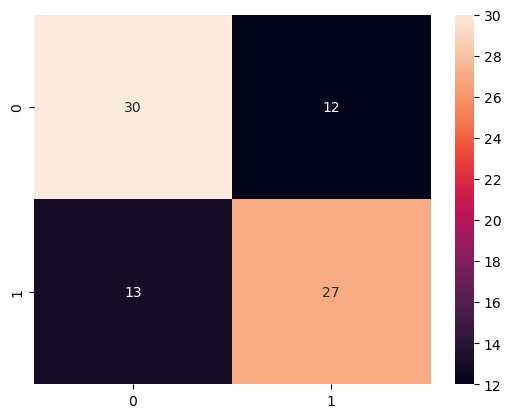

In [782]:
cm = confusion_matrix(grid_xgb.best_estimator_.predict(X_xgb_test),y_xgb_test)
sns.heatmap(cm, annot=True)
plt.show()

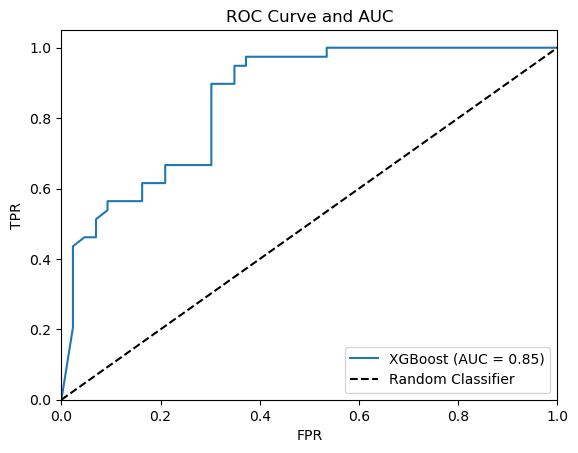

In [787]:
roc_plot([grid_xgb],['XGBoost'],X_scaled_test,y_scaled_test)

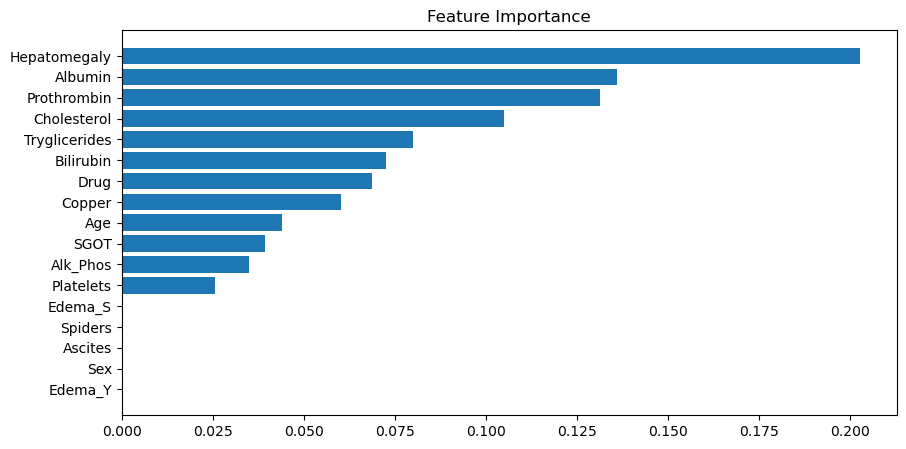

In [718]:
feature_importance = grid_xgb.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_xgb_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

### Naive Bayes Classifier

In [754]:
from sklearn.naive_bayes import GaussianNB
# training the Naive Bayes model on the training set
NBclassifier = GaussianNB()
NBclassifier.fit(X_scaled_train, y_scaled_train)

# predicting the test set results
nb_pred = NBclassifier.predict(X_scaled_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_scaled_test, nb_pred)))

Model accuracy score: 0.7439


In [755]:
# set parameters
nb_par = {'var_smoothing': (0,1e-9,1e-7, 1e-5, 1e-3), }

# with GridSearch
grid_search_gnb = GridSearchCV(
    estimator=NBclassifier,
    param_grid=nb_par,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5
)
nbcv=grid_search_gnb.fit(X_scaled_train, y_scaled_train)
nbcv_pred =nbcv.predict(X_scaled_test)
nb_cm = confusion_matrix(nbcv_pred, y_scaled_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_scaled_test, nbcv_pred)))

Model accuracy score: 0.6951


In [756]:
print('Training set score: {:.4f}'.format(nbcv.best_estimator_.score(X_scaled_train, y_scaled_train)))
print('Test set score: {:.4f}'.format(nbcv.best_estimator_.score(X_scaled_test, y_scaled_test)))

Training set score: 0.8179
Test set score: 0.6951


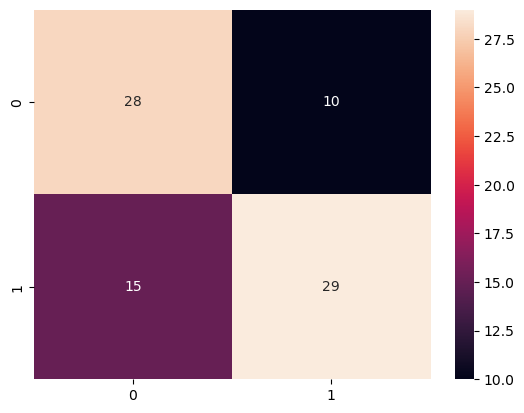

In [757]:
sns.heatmap(nb_cm, annot = True)
plt.show()

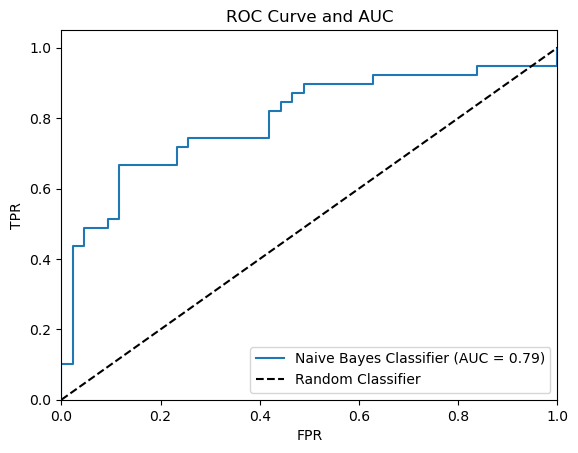

In [758]:
roc_plot([nbcv.best_estimator_],['Naive Bayes Classifier'],X_scaled_test,y_scaled_test)

### Linear Discriminant Analysis

In [759]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# training the LDA model on training set
lmodel = LinearDiscriminantAnalysis()
lda = lmodel.fit(X_scaled_train, y_scaled_train)

# predicting the test set results
lda_pred = lda.predict(X_scaled_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_scaled_test, lda_pred)))

Model accuracy score: 0.7317


In [760]:
lda2 = LinearDiscriminantAnalysis(shrinkage='auto')
lda_par = {
    'solver': ('lsqr','eigen'),
    'n_components': range(1,2),
                   }
# with GridSearch
grid_search_lda = GridSearchCV(
    estimator=lda2,
    param_grid=lda_par,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5
)
ldacv=grid_search_lda.fit(X_scaled_train, y_scaled_train)
ldacv_pred =ldacv.predict(X_scaled_test)
lda_cm = confusion_matrix(ldacv_pred, y_scaled_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_scaled_test, ldacv_pred)))

Model accuracy score: 0.7195


In [761]:
print('Training set score: {:.4f}'.format(ldacv.best_estimator_.score(X_scaled_train, y_scaled_train)))

print('Test set score: {:.4f}'.format(ldacv.best_estimator_.score(X_scaled_test, y_scaled_test)))

Training set score: 0.8086
Test set score: 0.7195


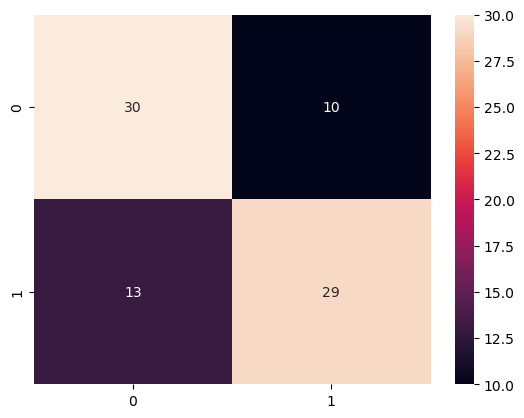

In [762]:
sns.heatmap(lda_cm, annot=True)
plt.show()

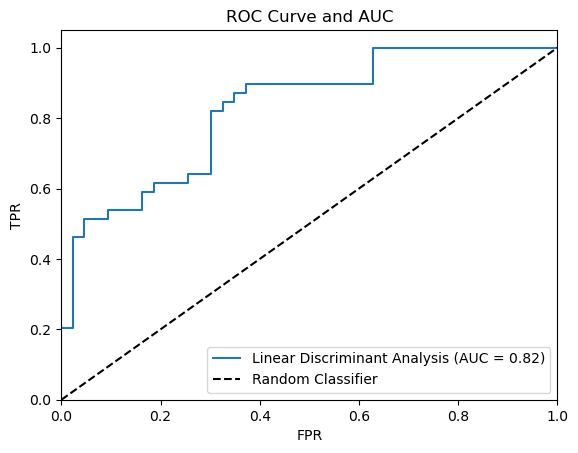

In [763]:
roc_plot([ldacv.best_estimator_],['Linear Discriminant Analysis'],X_scaled_test,y_scaled_test)

### Quadratic discriminant analysis

In [764]:
# training the QDA model on training set
qmodel = QuadraticDiscriminantAnalysis()
qda = qmodel.fit(X_scaled_train, y_scaled_train)

# predicting the test results
qda_pred = qda.predict(X_scaled_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_scaled_test, qda_pred)))

Model accuracy score: 0.7195


In [765]:
# initiate model and parameters for gridsearch
qda2 = QuadraticDiscriminantAnalysis()
qda_par = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001,0.01, 0.1), 
                   }
# with GridSearch
grid_search_qda = GridSearchCV(
    estimator=qda2,
    param_grid=qda_par,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5
)
qdacv=grid_search_qda.fit(X_scaled_train, y_scaled_train)
qdacv_pred =qdacv.predict(X_scaled_test)
qda_cm = confusion_matrix(qdacv_pred, y_scaled_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_scaled_test, qdacv_pred)))

Model accuracy score: 0.7439


In [766]:
print('Training set score: {:.4f}'.format(qdacv.best_estimator_.score(X_scaled_train, y_scaled_train)))
print('Test set score: {:.4f}'.format(qdacv.best_estimator_.score(X_scaled_test, y_scaled_test)))

Training set score: 0.8704
Test set score: 0.7439


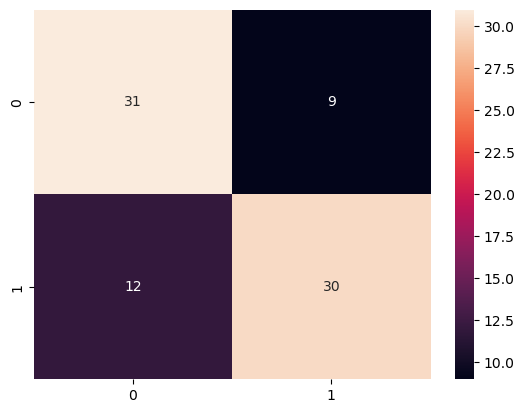

In [767]:
sns.heatmap(qda_cm, annot=True)
plt.show()

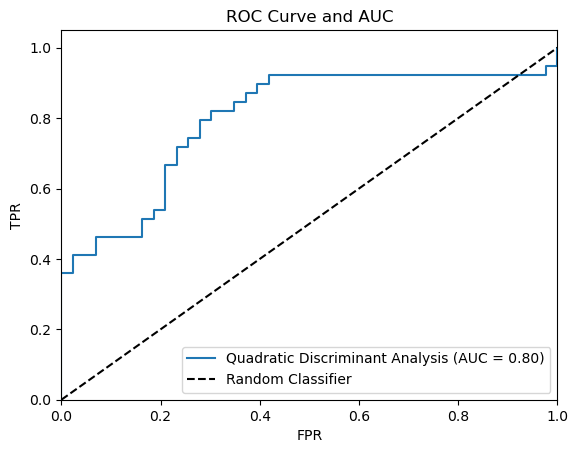

In [768]:
roc_plot([qdacv.best_estimator_],['Quadratic Discriminant Analysis'],X_scaled_test,y_scaled_test)

## Performance Evaluation

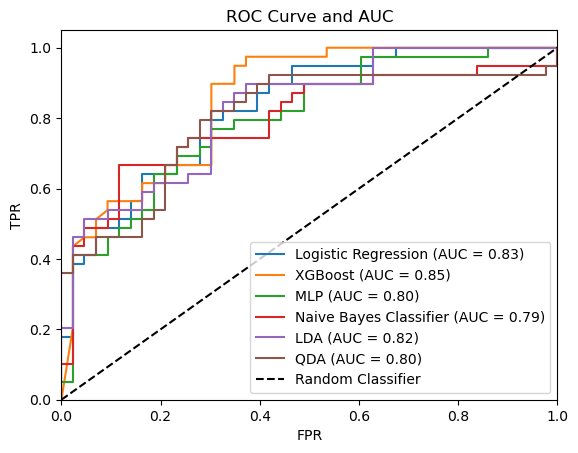

In [788]:
estimator_list = [lr_model,grid_xgb,mlp_grid,grid_search_gnb,grid_search_lda,grid_search_qda]
estimator_name_list = ["Logistic Regression", "XGBoost", "MLP",
                       "Naive Bayes Classifier","LDA","QDA"]
roc_plot(estimator_list,estimator_name_list,X_scaled_test,y_scaled_test)